In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle

import numpy as np
import numpy.lib.recfunctions as rfn

import matplotlib.pyplot as plt
import scipy.integrate, scipy.interpolate, scipy.stats

from astropy.table import Table

- Some of the calculation here also depends on the `awesome_cluster_finder` package by Christopher Bradshaw
    - It will be available [in this Github repo](https://github.com/Christopher-Bradshaw/awesome_cluster_finder)

- If you don't have access to `acf` or don't have space for downloading the data, you can load the saved data in this folder to reproduce the figure.


In [2]:
import awesome_cluster_finder as acf

Cosmology: Detected change in cosmological parameters.
Cosmology: Detected change in cosmological parameters.
updating config! Using simulation:cb_sham_mdpl:/home/christopher/research/cluster_finder/_data/cb_sham_mdpl/latest.npz

Fiducial cosmo
 Cosmology "planck15" 
    flat = True, Om0 = 0.3000, Ode0 = 0.6999, Ob0 = 0.0486, H0 = 70.00, sigma8 = 0.8159, ns = 0.9667
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False

Sim cosmo
 Cosmology "sim_cosmo" 
    flat = True, Om0 = 0.3071, Ode0 = 0.6928, Ob0 = 0.0482, H0 = 70.00, sigma8 = 0.8228, ns = 0.9600
    de_model = lambda, relspecies = True, Tcmb0 = 2.7255, Neff = 3.0460, powerlaw = False


In [13]:
import jianbing

In [16]:
fig_dir = jianbing.FIG_DIR

data_dir = jianbing.DATA_DIR

## Data

- We are using the halo catalogs and the particle files of the `MDPL2` simulation at z~0.4. 
- The halo catalogs and particles files are available in public.
    - For the halo catalog: We have made halo mass cut and only kept the useful columns.
    - For the particle files: We have downsampled the particles to 72 millions.
- These files are still very large. We will make the script to generate them available.

In [18]:
# Halo catalog
halo_cat = np.load(os.path.join(data_dir, 'mdpl2_halos_0.7333_reduced_logmvir_13.npy'))
halo_cat_new = rfn.rename_fields(halo_cat, {'halo_x': 'x', 'halo_y': 'y', 'halo_z': 'z'})

# Downsampled particle files
ptcl_cat = np.load(os.path.join(data_dir, 'mdpl2_particles_0.7333_72m.npy'))
particles = np.vstack([ptcl_cat["x"], ptcl_cat["y"], ptcl_cat["z"]]).T

In [13]:
def hmf_gen(norm):
    """Return a function that describes the exponentialy declining halo mass."""
    def hmf(params, pivot, mu):
        exponent = 0
        for i, p in enumerate(params):
            exponent -= p * (mu - pivot)**i / np.math.factorial(i)
        return np.exp(exponent) / norm
    return hmf

def draw_n_halo_mass(n_halo, hmf_use, halo_mass_bins):
    """Randomly draw N halo mass from a given halo mass function
    
    - Cumulatively integrate the HMF to get the "curve-of-growth" ranging between 0 and 1.
    - Then create an interpolation function between the cumulative curve and halo mass bins.
    - Randomly select N numbers ranging from 0 to 1, then interpolate to get the corresponding halo mass.
    """
    return scipy.interpolate.interp1d(
        scipy.integrate.cumtrapz(hmf_use, halo_mass_bins, initial=0),
        halo_mass_bins
    )(np.random.random(n_halo))

def p_s_in_bounds_given_mu(mu, sigma, s_low, s_upp):
    """Analytic number counts (eq 11 in Farahi).
    """
    mean_s = mean_s_from_mu(mu)
    dist = scipy.stats.norm(loc=mean_s, scale=sigma)
    return dist.cdf(s_upp) - dist.cdf(s_low)

def mean_mu_from_s(s, shift=True):
    """Simplified function to calculate mean halo mass at fixed observable."""
    sigma_square = sigma_s_at_mu ** 2
    alpha_square = alpha ** 2
    
    # This term comes from the fact that here we use a shifted HMF (with global pivot)
    if shift:
        pivot_shift = beta_2 * global_pivot * sigma_square
    else:
        pivot_shift = 0
    
    return (pivot_shift - beta_1 * sigma_square + s * alpha - alpha * pi) / (beta_2 * sigma_square + alpha_square)

def std_mu_from_s(s):
    """Simplified function to calculate the scatter of halo mass at fixed observable."""
    sigma_square = sigma_s_at_mu ** 2
    alpha_square = alpha ** 2
    
    return sigma_s_at_mu / np.sqrt(beta_2 * sigma_square + alpha_square)

### Default HMF used in this work

In [14]:
# Parameters for HMF
beta_0, beta_1, beta_2 = -0.558, 0.67, 2.959
global_pivot = 13.
global_params =  [beta_0, beta_1, beta_2]

# Lower and upper limits of halo mass function
hmf_lower, hmf_upper = 13, 15.5

# Halo mass bins
halo_mass_bins = np.linspace(hmf_lower, hmf_upper, num=1000)

# Get the corrected normalization of the HMF so that its integration from lower to upper boundaries equal 1
hmf_norm = scipy.integrate.trapz(
    hmf_gen(1.)(global_params, global_pivot, halo_mass_bins), halo_mass_bins)

# Function to generate HMF
hmf = hmf_gen(hmf_norm)

# Default halo mass functions
hmf_default = hmf(global_params, global_pivot, halo_mass_bins)

In [15]:
# Randomly draw halos from the HMF
n_draws = 5000000

### Fig 1A

In [16]:
# Relation 1 
alpha_1, pi_1 = 1.2, -5.7
sigma_s_at_mu_1 = 0.2
mean_s_from_mu_1 = lambda mu: pi_1 + alpha_1 * mu

# Sample 1
mu_random_1 = draw_n_halo_mass(n_draws, hmf_default, halo_mass_bins)
s_random_1 = np.random.normal(mean_s_from_mu_1(mu_random_1), sigma_s_at_mu_1)

sample_1 = Table()
sample_1['mu'] = mu_random_1
sample_1['s'] = s_random_1

s_min_1, s_max_1 = np.min(s_random_1), np.max(s_random_1)
s_mf_1, s_edge_1 = np.histogram(s_random_1, bins=50, density=True)
s_bins_1 = s_edge_1[:-1]

In [17]:
# Relation 2 
alpha_2, pi_2 = 0.8, -2.0
sigma_s_at_mu_2 = 0.4
mean_s_from_mu_2 = lambda mu: pi_2 + alpha_2 * mu

# Sample 1
mu_random_2 = draw_n_halo_mass(n_draws, hmf_default, halo_mass_bins)
s_random_2 = np.random.normal(mean_s_from_mu_2(mu_random_2), sigma_s_at_mu_2)

sample_2 = Table()
sample_2['mu'] = mu_random_2
sample_2['s'] = s_random_2

s_min_2, s_max_2 = np.min(s_random_2), np.max(s_random_2)
s_mf_2, s_edge_2 = np.histogram(s_random_2, bins=50, density=True)
s_bins_2 = s_edge_2[:-1]

In [18]:
# Relation 3 
alpha_3, pi_3 = 0.4, 2.6
sigma_s_at_mu_3 = 0.2
mean_s_from_mu_3 = lambda mu: pi_3 + alpha_3 * mu

# Sample 1
mu_random_3 = draw_n_halo_mass(n_draws, hmf_default, halo_mass_bins)
s_random_3 = np.random.normal(mean_s_from_mu_3(mu_random_3), sigma_s_at_mu_3)

sample_3 = Table()
sample_3['mu'] = mu_random_3
sample_3['s'] = s_random_3

s_min_3, s_max_3 = np.min(s_random_3), np.max(s_random_3)
s_mf_3, s_edge_3 = np.histogram(s_random_3, bins=50, density=True)
s_bins_3 = s_edge_3[:-1]

In [28]:
# Get the DSigma profiles
sim_n = [0, 5000]

demo_dsig_1 = []

for (slope, scatter) in [(alpha_1, sigma_s_at_mu_1), (alpha_2, sigma_s_at_mu_2), (alpha_3, sigma_s_at_mu_3)]:
    r, ds, ds_err = acf.delta_sigma.delta_sigma_with_scatter_and_slope(
        halo_cat_new, particles, scatter, slope, sim_n[0], sim_n[1])
    demo_dsig_1.append((r, ds, ds_err, slope, scatter))

In [29]:
# Save a copy of the data
demo_data_1 = {'sample_1': np.asarray(sample_1), 
               'sample_2': np.asarray(sample_2), 
               'sample_3': np.asarray(sample_3), 
               'demo_dsig_1': demo_dsig_1}

demo_file_1 = os.path.join(data_dir, "topn_theory_demo.pkl")
if not os.path.isfile(demo_file_1):
    pickle.dump(demo_data_1, open(demo_file_1, "wb"))

In [30]:
# Now let's select the top 5000 objects using observable 's'

# Fake TopN selection
sample_1.sort('s')
sample_2.sort('s')
sample_3.sort('s')

topn_1 = sample_1[-5000:]
topn_2 = sample_2[-5000:]
topn_3 = sample_3[-5000:]

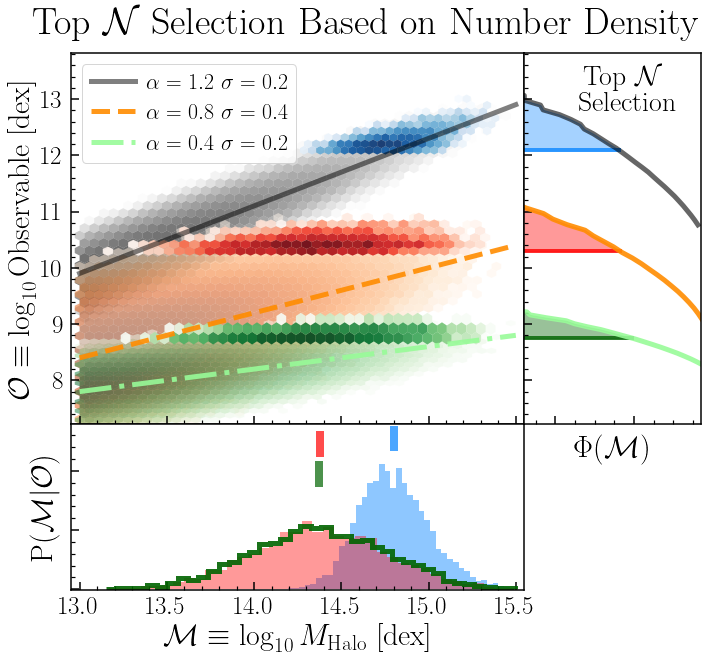

In [37]:
fig_1a = plt.figure(figsize=(10, 9.2))
fig_1a.suptitle(
    r'${\rm Top}\ \mathcal{N}\ {\rm Selection\ Based\ on\ Number\ Density}$', fontsize=38, x=0.53)

# Setup the three panels
ax1 = fig_1a.add_axes([0.12, 0.35, 0.63, 0.56])
ax2 = fig_1a.add_axes([0.12, 0.10, 0.63, 0.25])
ax3 = fig_1a.add_axes([0.75, 0.35, 0.245, 0.56])

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_yticklabels([])

# ------- Panel 1: 2-D Distribution ------- #
# Distributions of randomly selected mu and s

# Min / Max of X, Y axes
x_min = np.min([np.min(mu_random_1), np.min(mu_random_2)]) - 0.05
x_max = np.max([np.max(mu_random_1), np.max(mu_random_2)]) + 0.05

y_min = np.min([s_min_1, s_min_2]) + 0.90
y_max = np.max([s_max_1, s_max_2]) + 0.58

mu_arr = np.linspace(13.0, 15.5, 100)

hbin_1 = ax1.hexbin(mu_random_1, s_random_1, gridsize=(45, 16), bins='log', cmap='Greys', 
                    mincnt=4, edgecolor='none', alpha=0.6)

hbin_2 = ax1.hexbin(mu_random_2, s_random_2, gridsize=(45, 20), bins='log', cmap='Oranges', 
                    mincnt=4, edgecolor='none', alpha=0.5)

hbin_5 = ax1.hexbin(mu_random_3, s_random_3, gridsize=(45, 16), bins='log', cmap='Greens', 
                    mincnt=4, edgecolor='none', alpha=0.5)

hbin_3 = ax1.hexbin(topn_1['mu'], topn_1['s'], gridsize=(28, 5), bins='log', cmap='Blues', 
                    mincnt=4, edgecolor='none', alpha=0.9)

hbin_4 = ax1.hexbin(topn_2['mu'], topn_2['s'], gridsize=(42, 4), bins='log', cmap='Reds', 
                    mincnt=4, edgecolor='none', alpha=0.9)

hbin_6 = ax1.hexbin(topn_3['mu'], topn_3['s'], gridsize=(42, 2), bins='log', cmap='Greens', 
                    mincnt=4, edgecolor='none', alpha=0.9)

ax1.plot(mu_arr, alpha_1 * mu_arr + pi_1, linestyle='-', alpha=0.5, linewidth=5.0,
         color='k', label=r'$\alpha=1.2\ \sigma=0.2$')

ax1.plot(mu_arr, alpha_2 * mu_arr + pi_2, linestyle='--', alpha=0.9, linewidth=5.0,
         color='darkorange', label=r'$\alpha=0.8\ \sigma=0.4$')

ax1.plot(mu_arr, alpha_3 * mu_arr + pi_3, linestyle='-.', alpha=0.9, linewidth=5.0,
         color='palegreen', label=r'$\alpha=0.4\ \sigma=0.2$')

# Legend
ax1.legend(loc='upper left', fontsize=22, handletextpad=0.5)

_ = ax1.set_ylabel(r"$\mathcal{O} \equiv \log_{10} \rm Observable\ [\rm dex]$", fontsize=30)
_ = ax1.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# ------- Panel 2: mu Distribution ------- #
_, mu_bins_1, _ = ax2.hist(
    topn_1['mu'], density=True, alpha=0.5, bins=40, facecolor='dodgerblue', edgecolor='none')

_, mu_bins_2, _ = ax2.hist(
    topn_2['mu'], density=True, alpha=0.4, bins=40, facecolor='red', edgecolor='none')

_, mu_bins_3, _ = ax2.hist(
    topn_3['mu'], density=True, alpha=0.9, bins=40, linewidth=5.0, histtype='step', 
    facecolor='None', edgecolor='darkgreen')

_ = ax2.set_xlabel(r"$\mathcal{M} \equiv \log_{10} M_{\rm Halo}\ [\rm dex]$", fontsize=30)
_ = ax2.set_ylabel(r"${\rm P}(\mathcal{M} | \mathcal{O})$", fontsize=30)
_ = ax2.set_xlim(x_min, x_max)
y_lim = 3.5

# ------- Panel 3: s Distribution ------- #

topn_1_s_range = np.linspace(np.min(topn_1['s']), np.max(topn_1['s']), 100)
topn_1_mf_range = np.interp(topn_1_s_range, s_bins_1, np.log10(s_mf_1))

topn_2_s_range = np.linspace(np.min(topn_2['s']), np.max(topn_2['s']), 100)
topn_2_mf_range = np.interp(topn_2_s_range, s_bins_2, np.log10(s_mf_2))

topn_3_s_range = np.linspace(np.min(topn_3['s']), np.max(topn_3['s']), 100)
topn_3_mf_range = np.interp(topn_3_s_range, s_bins_3, np.log10(s_mf_3))

ax3.fill_between(topn_1_mf_range, np.full(100, np.min(topn_1_s_range)), topn_1_s_range,
                 alpha=0.4, color='dodgerblue')
ax3.fill_between(topn_2_mf_range, np.full(100, np.min(topn_2_s_range)), topn_2_s_range,
                 alpha=0.4, color='red')
ax3.fill_between(topn_3_mf_range, np.full(100, np.min(topn_3_s_range)), topn_3_s_range,
                 alpha=0.4, color='darkgreen')

ax3.plot([np.min(topn_3_mf_range), np.max(topn_1_mf_range)], [sample_1['s'][-5000], sample_1['s'][-5000]], 
         linestyle='-', linewidth=4, alpha=0.9, color='dodgerblue', zorder=0)

ax3.plot([np.min(topn_3_mf_range), np.max(topn_2_mf_range)], [sample_2['s'][-5000], sample_2['s'][-5000]], 
         linestyle='-', linewidth=4, alpha=0.8, color='red', zorder=0)

ax3.plot([np.min(topn_3_mf_range), np.max(topn_3_mf_range)], [sample_3['s'][-5000], sample_3['s'][-5000]], 
         linestyle='-', linewidth=4, alpha=0.8, color='darkgreen', zorder=0)

mask_1 = (s_bins_1 >= 10.7)
ax3.plot(np.log10(s_mf_1[mask_1]), s_bins_1[mask_1], linewidth=5.0, alpha=0.6, c='k')

mask_2 = (s_bins_2 >= 9.0)
ax3.plot(np.log10(s_mf_2[mask_2]), s_bins_2[mask_2], linewidth=5.0, alpha=0.9, c='darkorange')

mask_3 = (s_bins_3 >= 8.0)
ax3.plot(np.log10(s_mf_3[mask_3]), s_bins_3[mask_3], linewidth=5.0, alpha=0.9, c='palegreen')

_ = ax3.set_xlabel(r'$\Phi(\mathcal{M})$', fontsize=30)
_ = ax3.set_xlim(-4.78, -0.3)
_ = ax3.set_ylim(y_min, y_max)

ax2.plot([np.mean(topn_1['mu']), np.mean(topn_1['mu'])], [2.4, 2.7], linewidth=8, 
         color='dodgerblue', alpha=0.8)

ax2.plot([np.mean(topn_2['mu']), np.mean(topn_2['mu'])], [2.3, 2.6], linewidth=8, 
         color='red', alpha=0.7)

ax2.plot([np.mean(topn_3['mu']), np.mean(topn_3['mu'])], [1.8, 2.1], linewidth=8, 
         color='darkgreen', alpha=0.7)

ax2.set_ylim(-0.01, 2.79)

ax3.annotate(r"${\rm Top}\ \mathcal{N}$", (-3.3, 13.25), fontsize=28)
ax3.annotate(r"${\rm Selection}$", (-3.4, 12.8), fontsize=28)

fig_1a.savefig(os.path.join(fig_dir, 'fig_1a.pdf'), dpi=120)
fig_1a.savefig(os.path.join(fig_dir, 'fig_1a.png'), dpi=120)

### Fig 1b:

- Show the different $\Delta\Sigma$ profiles of number density selected sample using different scaling relations

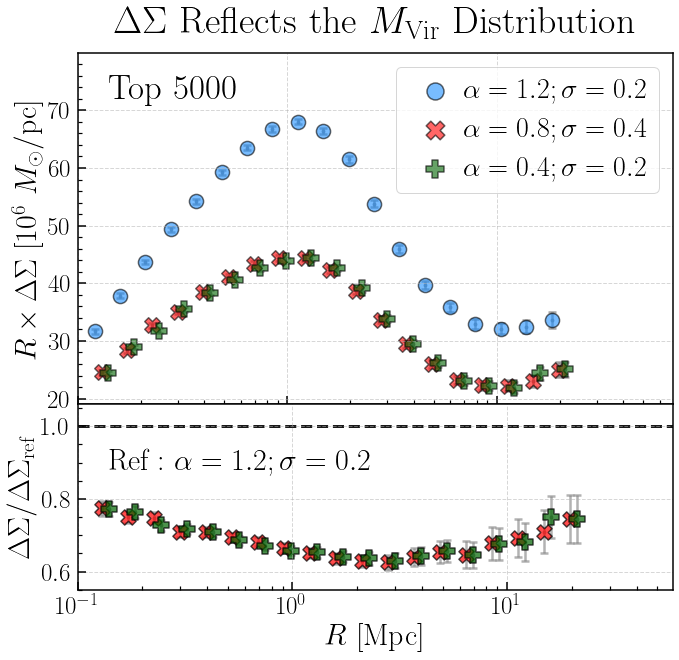

In [38]:
color_bins = ['dodgerblue', 'red', 'darkgreen']
marker_bins = ['o', 'X', 'P']
msize_bins = [200, 240, 240]

fig_1b = plt.figure(figsize=(9.5, 9.2))
fig_1b.suptitle(r'$\Delta\Sigma\ {\rm Reflects\ the}\ M_{\rm Vir}\ {\rm Distribution}$', 
                x=0.56, fontsize=38)

# Setup the three panels
ax1 = fig_1b.add_axes([0.125, 0.38, 0.87, 0.53])
ax2 = fig_1b.add_axes([0.125, 0.10, 0.87, 0.28])

ax1.set_xscale("log", nonpositive='clip')
ax2.set_xscale("log", nonpositive='clip')

ax2.axhline(1.0, linewidth=3.0, color='k', linestyle='--', zorder=0, alpha=0.9)

# ------- Panel 1: R x DeltaSigma profiles ------- #
# Reference DSigma profile
for ii, result in enumerate(demo_dsig_1):
    r_mpc, dsig, dsig_err, slope, scatter = result
    
    label_bin = r"$\alpha={:3.1f}; \sigma={:3.1f}$".format(slope, scatter)

    ax1.errorbar(
        r_mpc * (1.0 + ii * 0.08), r_mpc * dsig, yerr=(r_mpc * dsig_err),
        ecolor='grey', color='grey', alpha=0.7, capsize=4, 
        capthick=2.5, elinewidth=2.5, label='__no_label__', fmt='.', zorder=0)
    ax1.scatter(
        r_mpc * (1.0 + ii * 0.08), r_mpc * dsig, 
        s=msize_bins[ii], alpha=0.6, facecolor=color_bins[ii], edgecolor='k', marker=marker_bins[ii], 
        linewidth=1.5, label=label_bin)
    
    if ii == 0:
        dsig_ref, dsig_err_ref = dsig, dsig_err
    else:
        ratio_err = np.sqrt((dsig_err / dsig) ** 2 + (dsig_err_ref / dsig_ref) ** 2)
        ax2.errorbar(
            r_mpc * (1.0 + ii * 0.08), dsig / dsig_ref, yerr=ratio_err,
            ecolor='grey', color='grey', alpha=0.6, capsize=4, 
            capthick=2.5, elinewidth=2.5, label='__no_label__', fmt='.', zorder=0)
        ax2.scatter(
            r_mpc * (1.0 + ii * 0.08), dsig / dsig_ref, 
            s=230, alpha=0.7, facecolor=color_bins[ii], edgecolor='k', marker=marker_bins[ii], 
            linewidth=1.5, label=label_bin)

ax1.set_xticklabels([])
ax1.legend(loc='best', fontsize=28, handletextpad=0.06, markerscale=1.2)
_ = ax1.set_ylabel(r'$R \times \Delta\Sigma\ [10^{6}\ M_{\odot}/\mathrm{pc}]$', fontsize=30)
    
_ = ax2.set_xlabel(r'$R\ [\mathrm{Mpc}]$', fontsize=30)
_ = ax2.set_ylabel(r'$\Delta\Sigma / \Delta\Sigma_{\rm ref}$', fontsize=30)

ax1.set_xlim(0.1, 69)
ax1.set_ylim(19., 79.9)
ax2.set_xlim(0.1, 59)
ax2.set_ylim(0.55, 1.06)

ax1.text(0.14, 72, r'${\rm Top}\ 5000$', fontsize=35)
ax2.text(0.14, 0.88, r'${\rm Ref:}\ \alpha=1.2; \sigma=0.2$', fontsize=30)

fig_1b.savefig(os.path.join(fig_dir, 'fig_1b.pdf'), dpi=120)
fig_1b.savefig(os.path.join(fig_dir, 'fig_1b.png'), dpi=120)